# Imports

In [1]:
!pip install torchmetrics

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split

import torchvision
from torchvision.datasets import MNIST
from torchvision import transforms as T

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

from torchmetrics import Accuracy
from tqdm import tqdm

# Dataset

## Load Data

In [ ]:
MNIST('./dataset', download=1)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:02<00:00, 4297264.45it/s]


Extracting ./dataset/MNIST/raw/train-images-idx3-ubyte.gz to ./dataset/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 127299.80it/s]


Extracting ./dataset/MNIST/raw/train-labels-idx1-ubyte.gz to ./dataset/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:06<00:00, 242094.66it/s]


Extracting ./dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to ./dataset/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 3597154.22it/s]

Extracting ./dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./dataset/MNIST/raw



Dataset MNIST
    Number of datapoints: 60000
    Root location: ./dataset
    Split: Train

In [ ]:
transform_train = T.Compose([T.RandomCrop(28, padding=4),
                             T.RandomHorizontalFlip(),
                             T.ToTensor(),
                             T.Normalize(mean=(0.1307),
                                         std=(0.3081))])

transform_test = T.Compose([T.RandomCrop(28, padding=4),
                             T.RandomHorizontalFlip(),
                             T.ToTensor(),
                             T.Normalize(mean=(0.1325),
                                         std=(0.3105))])

train_set = MNIST('./dataset', train=1, transform=transform_train)
test_set = MNIST('./dataset', train=0, transform=transform_test)

x_train = train_set.data.unsqueeze(1)
x_test = test_set.data.unsqueeze(1)

y_train = train_set.targets
y_test = test_set.targets

print(f'x_train: {x_train.shape}, y_train: {y_train.shape}')
print(f'x_test: {x_test.shape}, y_test: {y_test.shape}')

x_train: torch.Size([60000, 1, 28, 28]), y_train: torch.Size([60000])
x_test: torch.Size([10000, 1, 28, 28]), y_test: torch.Size([10000])


In [ ]:
x_valid, x_test, y_valid, y_test = train_test_split(x_test, y_test, test_size=0.5, random_state=42)

print(f'x_train: {x_train.shape}, y_train: {y_train.shape}')
print(f'x_test: {x_test.shape}, y_test: {y_test.shape}')
print(f'x_valid: {x_valid.shape}, y_valid: {y_valid.shape}')

x_train: torch.Size([60000, 1, 28, 28]), y_train: torch.Size([60000])
x_test: torch.Size([5000, 1, 28, 28]), y_test: torch.Size([5000])
x_valid: torch.Size([5000, 1, 28, 28]), y_valid: torch.Size([5000])


## Data Loader

In [ ]:
train_dataset = TensorDataset(x_train, y_train)
valid_dataset = TensorDataset(x_valid, y_valid)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False)

In [ ]:
x_batch, y_batch = next(iter(train_loader))

x_batch.shape, y_batch.shape

(torch.Size([64, 1, 28, 28]), torch.Size([64]))

# Model

In [ ]:
class CNNModel(nn.Module):

  def __init__(self, in_channels):
    super().__init__()
    self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=32, kernel_size=(3, 3), stride=2, padding=1)
    self.bn1 = nn.BatchNorm2d(32)
    self.af = nn.ReLU()

    self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), stride=1, padding=1)
    self.bn2 = nn.BatchNorm2d(32)

    self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(1, 1), stride=1, padding=1)
    self.bn3 = nn.BatchNorm2d(64)

    self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), stride=2, padding=1)
    self.bn4 = nn.BatchNorm2d(64)

    self.conv5 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(1, 1), stride=1, padding=1)
    self.bn5 = nn.BatchNorm2d(128)

    self.conv6 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), stride=2, padding=1)
    self.bn6 = nn.BatchNorm2d(128)

    self.conv7 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(1, 1), stride=1, padding=1)
    self.bn7 = nn.BatchNorm2d(128)

    self.conv8 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), stride=2, padding=1)
    self.bn8 = nn.BatchNorm2d(128)

    self.conv9 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(1, 1), stride=1, padding=1)
    self.bn9 = nn.BatchNorm2d(256)

    self.conv10 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3, 3), stride=1, padding=1)
    self.bn10 = nn.BatchNorm2d(256)

    self.conv11 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(1, 1), stride=1, padding=1)
    self.bn11 = nn.BatchNorm2d(256)

    self.conv12 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3, 3), stride=1, padding=1)
    self.bn12 = nn.BatchNorm2d(256)

    self.conv13 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=(1, 1), stride=1, padding=1)
    self.bn13 = nn.BatchNorm2d(512)

    self.conv14 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(3, 3), stride=1, padding=1)
    self.bn14 = nn.BatchNorm2d(512)

    self.conv15 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(1, 1), stride=1, padding=1)
    self.bn15 = nn.BatchNorm2d(512)

    self.conv16 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(3, 3), stride=2, padding=1)
    self.bn16 = nn.BatchNorm2d(512)

    self.conv17 = nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=(1, 1), stride=1, padding=1)
    self.bn17 = nn.BatchNorm2d(1024)

    self.conv18 = nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=(3, 3), stride=1, padding=1)
    self.bn18 = nn.BatchNorm2d(1024)

    self.conv19 = nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=(1, 1), stride=1, padding=1)
    self.bn19 = nn.BatchNorm2d(1024)

    self.adaptive_avg_pool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
    self.linear = nn.Linear(1024, 10)

    self.conv_layers = [self.conv1, self.conv2, self.conv3, self.conv4, self.conv5,
                        self.conv6, self.conv7, self.conv8, self.conv9, self.conv10,
                        self.conv11, self.conv12, self.conv13, self.conv14, self.conv15,
                        self.conv16, self.conv17, self.conv18, self.conv19]

    self.bn_layers = [self.bn1, self.bn2, self.bn3, self.bn4, self.bn5,
                        self.bn6, self.bn7, self.bn8, self.bn9, self.bn10,
                        self.bn11, self.bn12, self.bn13, self.bn14, self.bn15,
                        self.bn16, self.bn17, self.bn18, self.bn19]

  def forward(self, x):
    x = torch.tensor(x, dtype=torch.float32)
    for conv, bn in zip(self.conv_layers, self.bn_layers):
      x = self.af(bn(conv(x)))
    x = self.adaptive_avg_pool(x)
    x = x.flatten(1)
    y = self.linear(x)
    return y

# Device

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# Utils

In [ ]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

# Functions

In [ ]:
def train_one_epoch(model, train_loader, loss_fn, optimizer, epoch=None):
  model.train()
  loss_train = AverageMeter()
  acc_train = Accuracy(task='multiclass', num_classes=10).to(device)
  with tqdm(train_loader, unit="batch") as tepoch:
    for inputs, targets in tepoch:
      if epoch is not None:
        tepoch.set_description(f"Epoch {epoch}")
      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)

      loss = loss_fn(outputs, targets)

      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

      loss_train.update(loss.item())
      acc_train(outputs, targets.int())
      tepoch.set_postfix(loss=loss_train.avg,
                         accuracy=100.*acc_train.compute().item())
  return model, loss_train.avg, acc_train.compute().item()

In [ ]:
def validation(model, test_loader, loss_fn):
  model.eval()
  with torch.no_grad():
    loss_valid = AverageMeter()
    acc_valid = Accuracy(task='multiclass', num_classes=10).to(device)
    for i, (inputs, targets) in enumerate(test_loader):
      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)
      loss = loss_fn(outputs, targets)

      loss_valid.update(loss.item())
      acc_valid(outputs, targets.int())
  return loss_valid.avg, acc_valid.compute().item()

# Efficient way for set hyperparams

## Check forward path

In [ ]:
x_batch, y_batch = next(iter(train_loader))
loss_fn = nn.CrossEntropyLoss()
model = CNNModel(1).to(device)
outputs = model(x_batch.to(device))
loss = loss_fn(outputs, y_batch.to(device))

print(loss)

<ipython-input-8-19390b2d1943>:77: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32)


tensor(2.3181, device='cuda:0', grad_fn=<NllLossBackward0>)


## Check backward path

In [ ]:
_, mini_train_dataset = random_split(train_dataset, (len(train_dataset)-1000, 1000))
mini_train_loader = DataLoader(mini_train_dataset, batch_size=20)

In [ ]:
loss_fn = nn.CrossEntropyLoss()
model = CNNModel(in_channels=1).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.1)
num_epochs = 10
for epoch in range(num_epochs):
  model, _, _ = train_one_epoch(model, mini_train_loader, loss_fn, optimizer, epoch)

Epoch 0:   0%|          | 0/50 [00:00<?, ?batch/s]<ipython-input-8-19390b2d1943>:77: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32)
Epoch 9: 100%|██████████| 50/50 [00:02<00:00, 24.76batch/s, accuracy=96.5, loss=0.108]


## Select Best lr

In [ ]:
num_epochs = 2
loss_fn = nn.CrossEntropyLoss()
for lr in [0.01, 0.1, 0.9]:
  print(f'LR: {lr}')
  model = CNNModel(in_channels=1).to(device)
  optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=1e-4)
  for epoch in range(num_epochs):
    model, _, _ = train_one_epoch(model, train_loader, loss_fn, optimizer, epoch)

LR: 0.01


Epoch 0:   0%|          | 0/938 [00:00<?, ?batch/s]<ipython-input-8-19390b2d1943>:77: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32)
Epoch 1: 100%|██████████| 938/938 [01:32<00:00, 10.15batch/s, accuracy=98.3, loss=0.0625]


LR: 0.1


Epoch 1: 100%|██████████| 938/938 [01:32<00:00, 10.19batch/s, accuracy=98.4, loss=0.0546]


LR: 0.9


Epoch 1: 100%|██████████| 938/938 [01:31<00:00, 10.29batch/s, accuracy=96.9, loss=0.113]


## Train more epoch

In [ ]:
model = CNNModel(in_channels=1).to(device)

lr = 0.5
wd = 1e-4
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd)

loss_train_hist = []
loss_valid_hist = []

acc_train_hist = []
acc_valid_hist = []

best_loss_valid = torch.inf
epoch_counter = 0

num_epochs = 10

for epoch in range(num_epochs):
  # Train
  model, loss_train, acc_train = train_one_epoch(model,
                                                 train_loader,
                                                 loss_fn,
                                                 optimizer,
                                                 epoch)
  # Validation
  loss_valid, acc_valid = validation(model,
                                     valid_loader,
                                     loss_fn)

  loss_train_hist.append(loss_train)
  loss_valid_hist.append(loss_valid)

  acc_train_hist.append(acc_train)
  acc_valid_hist.append(acc_valid)

  if loss_valid < best_loss_valid:
    torch.save(model, f'model.pt')
    best_loss_valid = loss_valid

  print(f'Valid: Loss = {loss_valid:.4}, Acc = {acc_valid:.4}')
  print()

  epoch_counter += 1

Epoch 0:   0%|          | 0/938 [00:00<?, ?batch/s]<ipython-input-8-19390b2d1943>:77: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32)
Epoch 0: 100%|██████████| 938/938 [01:31<00:00, 10.21batch/s, accuracy=85.6, loss=0.43]


Valid: Loss = 0.08992, Acc = 0.975



Epoch 1: 100%|██████████| 938/938 [01:31<00:00, 10.27batch/s, accuracy=97.7, loss=0.0785]


Valid: Loss = 0.06605, Acc = 0.982



Epoch 2: 100%|██████████| 938/938 [01:31<00:00, 10.27batch/s, accuracy=98.5, loss=0.054]


Valid: Loss = 0.06925, Acc = 0.979



Epoch 3: 100%|██████████| 938/938 [01:31<00:00, 10.24batch/s, accuracy=98.8, loss=0.0419]


Valid: Loss = 0.1965, Acc = 0.9432



Epoch 4: 100%|██████████| 938/938 [01:31<00:00, 10.27batch/s, accuracy=98.9, loss=0.0379]


Valid: Loss = 0.04073, Acc = 0.9892



Epoch 5: 100%|██████████| 938/938 [01:31<00:00, 10.24batch/s, accuracy=99.1, loss=0.0308]


Valid: Loss = 0.0338, Acc = 0.9896



Epoch 6: 100%|██████████| 938/938 [01:31<00:00, 10.27batch/s, accuracy=99.1, loss=0.0296]


Valid: Loss = 0.07042, Acc = 0.9812



Epoch 7: 100%|██████████| 938/938 [01:31<00:00, 10.30batch/s, accuracy=99.3, loss=0.0256]


Valid: Loss = 0.04698, Acc = 0.9868



Epoch 8: 100%|██████████| 938/938 [01:31<00:00, 10.30batch/s, accuracy=99.3, loss=0.0251]


Valid: Loss = 0.03262, Acc = 0.989



Epoch 9: 100%|██████████| 938/938 [01:31<00:00, 10.30batch/s, accuracy=99.3, loss=0.0234]


Valid: Loss = 0.02952, Acc = 0.9912



## Plot

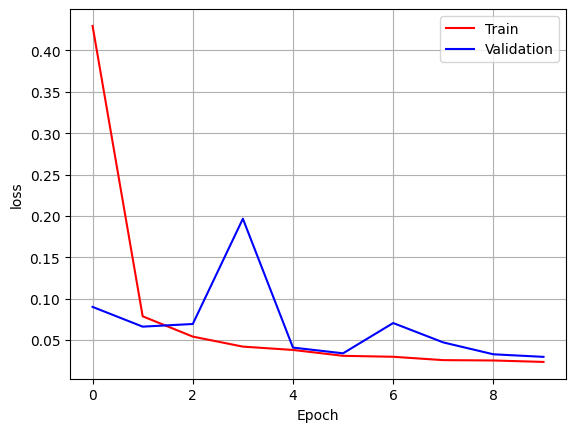

In [ ]:
plt.plot(range(epoch_counter), loss_train_hist, 'r-', label='Train')
plt.plot(range(epoch_counter), loss_valid_hist, 'b-', label='Validation')

plt.xlabel('Epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()

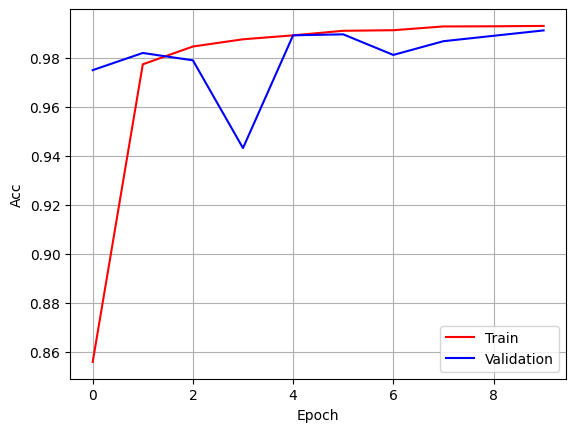

In [ ]:
plt.plot(range(epoch_counter), acc_train_hist, 'r-', label='Train')
plt.plot(range(epoch_counter), acc_valid_hist, 'b-', label='Validation')

plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.grid(True)
plt.legend()